In [2]:
#some library imports
import pandas as pd
from glob import glob
from tqdm import tqdm
import os
import re
import datetime

In [83]:
df=pd.read_csv('dataset.csv')

/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
df.head()

,date,commiter,commit_insertion,commit_deletion,file_language,is_bug,filename,sha,message,project,github_language
0,Wed Dec 11 13:29:19 2019 +0100,Oliver Eyton-Williamsojeytonwilliams@gmail.com,14,4,JavaScript,0.0,client/src/templates/Challenges/utils/frame.js,d6c53eb9142d1986e15b09435cb1191bd35c3aae,fix(client): report cross origin errors (#...,freeCodeCamp/freeCodeCamp,JavaScript
1,Wed Dec 11 06:43:06 2019 -0500,Catalinaionescuc@dickinson.edu,20,9,JavaScript,0.0,api-server/common/models/user.js,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,freeCodeCamp/freeCodeCamp,JavaScript
2,Wed Dec 11 06:43:06 2019 -0500,Catalinaionescuc@dickinson.edu,14,11,JavaScript,0.0,api-server/server/boot/settings.js,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,freeCodeCamp/freeCodeCamp,JavaScript
3,Wed Dec 11 06:43:06 2019 -0500,Catalinaionescuc@dickinson.edu,1,0,JavaScript,0.0,api-server/server/utils/auth.js,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,freeCodeCamp/freeCodeCamp,JavaScript
4,Wed Dec 11 06:43:06 2019 -0500,Catalinaionescuc@dickinson.edu,1,0,JavaScript,0.0,api-server/server/utils/publicUserProps.js,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,freeCodeCamp/freeCodeCamp,JavaScript


In [85]:
df.dtypes

date                 object
commiter             object
commit_insertion     object
commit_deletion      object
file_language        object
is_bug              float64
filename             object
sha                  object
message              object
project              object
github_language      object
dtype: object

In [86]:
df=df[~(df['commit_insertion']=='mono/mono')]

In [87]:
num_commits=df.groupby(['github_language', 'project']).sha.nunique()
num_commits

github_language  project                           
Assembly         0xAX/asm                                19
                 KnightOS/KnightOS                      447
                 Overv/MineAssemble                      57
                 PDP-10/its                              15
                 ReturnInfinity/BareMetal-OS-legacy     282
                                                       ... 
TypeScript       t4t5/sweetalert                        160
                 tensorflow/tfjs                       2749
                 typeorm/typeorm                       2405
                 ustbhuangyi/better-scroll              846
                 vuetifyjs/vuetify                     4548
Name: sha, Length: 834, dtype: int64

In [88]:
#compute quantiles
quantiles=pd.DataFrame(num_commits).quantile([0.25,0.5,0.75])
#get the first quantile value for number of commits
first_quartile_commits=quantiles.values[0][0]
quantiles

,sha
0.25,183.0
0.50,826.5
0.75,3089.0


In [89]:
projects_to_neglect=num_commits[num_commits<first_quartile_commits].reset_index(name='count')['project'].values.tolist()

In [90]:
df=df[~df.project.isin(projects_to_neglect)]

In [91]:
commit_langs=df.groupby(['github_language', 'project','file_language']).sha.nunique()
commit_langs

github_language  project                             file_language
Assembly         KnightOS/KnightOS                   Assembly          432
                                                     C#                 37
                 ReturnInfinity/BareMetal-OS-legacy  Assembly          218
                                                     C                  91
                                                     JavaScript          4
                                                                      ... 
TypeScript       typeorm/typeorm                     TypeScript       2401
                 ustbhuangyi/better-scroll           JavaScript        567
                                                     TypeScript        310
                 vuetifyjs/vuetify                   JavaScript       3765
                                                     TypeScript       1055
Name: sha, Length: 2463, dtype: int64

In [92]:
#compute quantiles
lang_quantiles=pd.DataFrame(commit_langs).quantile([0.25,0.5,0.75])
#get the first quantile value for number of commits
first_quartile_lang=lang_quantiles.values[0][0]
lang_quantiles

,sha
0.25,6.0
0.50,63.0
0.75,666.0


In [93]:
ignore_langs=commit_langs[commit_langs<=first_quartile_lang].reset_index(name='count')
ignore_langs

,github_language,project,file_language,count
0,Assembly,ReturnInfinity/BareMetal-OS-legacy,JavaScript,4
1,Assembly,algorithm-archivists/algorithm-archive,Assembly,2
2,Assembly,algorithm-archivists/algorithm-archive,CoffeeScript,1
3,Assembly,algorithm-archivists/algorithm-archive,Lua,6
4,Assembly,cjdelisle/cjdns,Assembly,2
...,...,...,...,...
623,TypeScript,pubkey/rxdb,Objective-C,3
624,TypeScript,react-navigation/react-navigation,C,6
625,TypeScript,react-navigation/react-navigation,Objective-C,6
626,TypeScript,tensorflow/tfjs,Java,5


In [94]:
projects_lang_ignore=ignore_langs.project.unique()
len(projects_lang_ignore)

337

In [95]:
for project in tqdm(projects_lang_ignore):
    file_langs=ignore_langs[ignore_langs['project']==project]['file_language'].tolist()
    df=df[~(df['project'].isin([project]) &
                          df.file_language.isin(file_langs))]

100%|██████████| 337/337 [10:53<00:00,  1.94s/it]


In [3]:
bug_fix_df=pd.read_csv('commit_classification.csv')
bug_fix_df.head(10)

,sha,message,bugfix
0,d6c53eb9142d1986e15b09435cb1191bd35c3aae,fix(client): report cross origin errors (#...,1
1,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,1
2,0f5b9f8764e580566dca1300563cba86359b98da,fix(client): temporary redirect for donati...,1
3,c40680b81e6c62332392ec6c66ccc5a2b17ebf2e,fix(client): remove donate settings page,1
4,6a91f7c5b2ba8ea5203bd7d934e07555486ef746,fix(client): add missing bootstrap contain...,1
5,3f075f91d86c22fb44a1c75c90d8a3ad5e5cec8d,feat: activate progress based donation mod...,0
6,f1ddec3f9bb5766bfeb88956adda238923d5212e,fix(donate): hide legacy tiers (#37853),1
7,cb3524ee31764dbc02214e11891962356910e708,fix: simplify challenge teststring (#37826),1
8,623c08cbfafac061bfa55a26baec48b581a41b74,fix: removed semi-colon from regex (#37881),1
9,ccbc9cc6b67a8d3db4bba47d4a2d5a0b53badeb4,forum link fixed (#37260),1


In [4]:
def read_keywords(filename):
    f=open(filename).read()
    f=f.split('\n')
    keywords=[]
    for keyword in f:
        if keyword!='':
            keywords.append(keyword)
    return keywords

In [5]:
#CAUSE
Algo=read_keywords('keywords/algo_keywords.txt')
Conc=read_keywords('keywords/Conc_keywords.txt')
Mem=read_keywords('keywords/mem_keywords.txt')
Prog=read_keywords('keywords/prog_keywords.txt')
#IMPACT
Sec=read_keywords('keywords/sec_keywords.txt')
Perf=read_keywords('keywords/perf_keywords.txt')
Fail=read_keywords('keywords/fail_keywords.txt')

In [6]:
# #bug specific keywords
# #used from 2016 paper
# #CAUSE
# Algo=['algorithm','algo']

# Conc=['deadlock', 'race condition', 'synchronization error','mutex', 'semaphore',
#       'starvation', 'locking', 'multiple threads']

# Mem=['memory leak', 'null pointer', 'buffer overflow', 'heap overflow', 'dangling pointer',
#      'double free','overflow', 'dangling pointer', 'double free','segmentation fault', 'segfault', 'space leak',
#      'dereference', 'memory corruption', 'memory overrun', 'heap overrun']

# Prog=['exception handling', 'error handling', 'type error','typo', 'compilation error', 'copy-paste error',
#       'refactoring', 'missing switch case', 'faulty initialization', 'default value', 'declaration', 'syntax',
#       'counter', 'signature', 'variable', 'regexp', 'cut-paste,error', 'operator', 'inconsistent name', 'parameter',
#       'argument', 'procedure']

# #IMPACT
# Sec=['buffer overflow', 'security', 'password', 'oauth','ssl','vulnerability', 'attack']

# Perf=['optimization problem','performance', 'latency','speed', 'delayed','throughput']

# Fail=['reboot', 'crash', 'hang', 'restart', 'freeze']


In [7]:
import numpy as np
def categorize_cause(commit):
    classes=['Algo','Conc','Mem','Prog']
    hits=[0,0,0,0]
    for keyword in Algo:
        if keyword in commit:
            hits[0]+=1
    for keyword in Conc:
        if keyword in commit:
            hits[1]+=1
    for keyword in Mem:
        if keyword in commit:
            hits[2]+=1
    for keyword in Prog:
        if keyword in commit:
            hits[3]+=1
    if np.sum(hits)==0:
        return 'Unkn'
    else:
        return classes[np.argmax(hits)]

def categorize_impact(commit):
    classes=['Sec','Perf','Fail']
    hits=[0,0,0]
    for keyword in Sec:
        if keyword in commit:
            hits[0]+=1
    for keyword in Perf:
        if keyword in commit:
            hits[1]+=1
    for keyword in Fail:
        if keyword in commit:
            hits[2]+=1
    if np.sum(hits)==0:
        return 'Unkn'
    else:
        return classes[np.argmax(hits)]

In [8]:
pos_bug_fix_df=bug_fix_df[bug_fix_df['bugfix']==1]

In [9]:
import numpy as np
np.random.seed(42)

In [10]:
#without replacment
random_sample=pos_bug_fix_df.sample(frac=0.1)
random_sample

,sha,message,bugfix
4626936,219d44b08c350918b651c4ba806701b18d3d76fe,corrected tvos platform identifiers. ...,1
4013971,2e2185165c8f7111c2df1ca180dfb29fb3878915,improve test suite fix bug in set.global(),1
4695712,d8155bd7e33f08e3e799e999d5a4077608efc1c0,windows compatibility fixes with ...,1
1598060,692175901dccb5c7a01f34763467a133886b5704,fix randomnodeprovider behavior on 32-bit ...,1
1215836,644a92f1582ceeda6981c0653a5e455f5ec43e3c,fix rollup on date fields that don't suppo...,1
...,...,...,...
107666,5f047fedfc5a166ff3092a0359bca8aa5f8cad11,fixed bad revert.,1
100998,34781f18cb75ded9ae29f4b78f5bacd079f76709,fix(ngsanitize): ensure `html` is a string...,1
1766288,3bd5a09b529c03bac354c9d48e688ed2aca934fd,bpf: fix formatting for bpf_perf_event_rea...,1
1060654,11731fcbcf97af8b9232b8dfc249302a21c4f71e,fixed some rendering problems with the boo...,1


In [11]:
random_sample['message']=random_sample['message'].astype(str)

In [12]:
tqdm.pandas()

/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
random_sample['cause']=random_sample['message'].progress_apply(lambda x: categorize_cause(x))
random_sample['impact']=random_sample['message'].progress_apply(lambda x: categorize_impact(x))

100%|██████████| 133688/133688 [00:01<00:00, 74846.92it/s]


In [14]:
random_sample['cause'].value_counts()

Unkn    100764
Prog     21308
Mem       6905
Conc      2855
Algo      1856
Name: cause, dtype: int64

In [15]:
random_sample['impact'].value_counts()

Unkn    114074
Fail     12772
Sec       5011
Perf      1831
Name: impact, dtype: int64

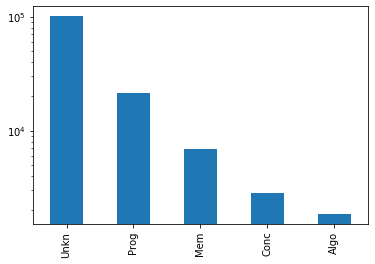

In [16]:
random_sample['cause'].value_counts().plot(kind='bar',logy=True)

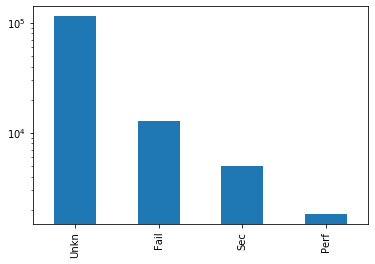

In [17]:
random_sample['impact'].value_counts().plot(kind='bar',logy=True)

In [18]:
temp_unkn=random_sample[random_sample['impact']=='Unkn']
temp_unkn=temp_unkn[temp_unkn['cause']=='Unkn']
temp_unkn

,sha,message,bugfix,cause,impact
4626936,219d44b08c350918b651c4ba806701b18d3d76fe,corrected tvos platform identifiers. ...,1,Unkn,Unkn
4013971,2e2185165c8f7111c2df1ca180dfb29fb3878915,improve test suite fix bug in set.global(),1,Unkn,Unkn
1598060,692175901dccb5c7a01f34763467a133886b5704,fix randomnodeprovider behavior on 32-bit ...,1,Unkn,Unkn
4248273,a3587beffef661e9bee6f1a31551f862c4caa3f3,arm: looprestoration: fix a comment to use...,1,Unkn,Unkn
667235,fc60bcecd6a0e38dd6fc5d5073f46053332af5a7,fixed not being able to pass the key via c...,1,Unkn,Unkn
...,...,...,...,...,...
967828,bfbae50e5a64c6417197cd0d793d955d537610c1,update a few things for the asset pipeline...,1,Unkn,Unkn
2107810,0abb6aeacc20822cd7baee82fd3b61169ca3f32e,arm: dts: correct the base address of pinc...,1,Unkn,Unkn
107666,5f047fedfc5a166ff3092a0359bca8aa5f8cad11,fixed bad revert.,1,Unkn,Unkn
1766288,3bd5a09b529c03bac354c9d48e688ed2aca934fd,bpf: fix formatting for bpf_perf_event_rea...,1,Unkn,Unkn


In [19]:
# Python program to find the k most frequent words 
# from data set 
from collections import Counter 
# Pass the split_it list to instance of Counter class. 
Counter = Counter(temp_unkn['message'].str.cat(sep=' ').split())
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(100) 
  
print(most_occur)

[('the', 63357), ('fix', 44372), ('to', 38480), ('in', 30166), ('a', 23297), ('for', 22628), ('is', 20371), ('and', 19888), ('of', 19199), ('fixes', 15334), ('signed-off-by:', 14953), ('this', 14641), ('on', 12426), ('when', 12051), ('*', 11992), ('not', 11489), ('with', 10666), ('fixed', 10372), ('it', 10224), ('that', 10085), ('if', 8736), ('from', 7976), ('be', 7784), ('by', 7220), ('we', 6925), ('as', 6701), ('add', 6427), ('-', 6384), ('bug', 5980), ('an', 5742), ('was', 5350), ('error', 5332), ('use', 5039), ('are', 4765), ('git-svn-id:', 4560), ('issue', 3727), ('so', 3682), ('some', 3669), ('code', 3667), ('which', 3608), ('but', 3434), ('should', 3372), ('missing', 3244), ('will', 3192), ('only', 3113), ('patch', 3097), ('set', 3080), ('test', 3000), ('check', 2978), ('can', 2954), ('remove', 2925), ('build', 2909), ('no', 2779), ('added', 2759), ('have', 2737), ('at', 2733), ('update', 2720), ('return', 2719), ('make', 2702), ('all', 2687), ('after', 2682), ('also', 2604), ('

In [20]:
temp_impact=random_sample[random_sample['impact']!='Unkn']
temp_cause=random_sample[random_sample['cause']!='Unkn']

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2,stop_words='english',max_features=4096)
vectorizer.fit(random_sample['message'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=4096,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [67]:
X_cause=vectorizer.transform(temp_cause['message'].values)
X_impact=vectorizer.transform(temp_impact['message'].values)

y_cause=temp_cause['cause'].values
y_impact=temp_impact['impact'].values

In [68]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [69]:
X_train_cause, X_test_cause, y_train_cause, y_test_cause = train_test_split(X_cause, y_cause,
                                                                            test_size=0.33, random_state=42)
X_train_impact, X_test_impact, y_train_impact, y_test_impact = train_test_split(X_impact, y_impact,
                                                    test_size=0.33, random_state=42)

In [70]:
from sklearn.ensemble import ExtraTreesClassifier

In [71]:
clf_cause = ExtraTreesClassifier(n_jobs=-1,random_state=42)
clf_cause.fit(X_train_cause, y_train_cause)
y_pred_cause=clf_cause.predict(X_test_cause)
print(classification_report(y_test_cause, y_pred_cause))

/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        Algo       0.97      0.71      0.82       640
        Conc       0.90      0.78      0.84       943
         Mem       0.89      0.84      0.86      2294
        Prog       0.92      0.97      0.94      6988

    accuracy                           0.91     10865
   macro avg       0.92      0.83      0.87     10865
weighted avg       0.91      0.91      0.91     10865



In [72]:
clf_impact = ExtraTreesClassifier(n_jobs=-1,random_state=42)
clf_impact.fit(X_train_impact, y_train_impact) 
y_pred_impact=clf_impact.predict(X_test_impact)
print(classification_report(y_test_impact, y_pred_impact))

/home/sarim/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        Fail       0.90      0.98      0.94      4260
        Perf       0.94      0.74      0.83       609
         Sec       0.91      0.78      0.84      1604

    accuracy                           0.90      6473
   macro avg       0.92      0.83      0.87      6473
weighted avg       0.91      0.90      0.90      6473



In [73]:
del(X_cause)
del(X_impact)
del(X_train_impact)
del(X_train_cause)
del(X_test_cause)
del(X_test_impact)

In [74]:
bug_fix_df['message']=bug_fix_df['message'].astype(str)

In [75]:
vectors=vectorizer.transform(bug_fix_df['message'])
cause_preds=clf_cause.predict(vectors)
impact_preds=clf_impact.predict(vectors)

In [76]:
counter=0
def categorize_commits(record):
    #print(record)
    global counter
    response={'Algo':0,
             'Conc':0,
             'Mem':0,
             'Prog':0,
              'Fail':0,
              'Perf':0,
              'Sec':0
             }
    if record['bugfix']==1:
        response[cause_preds[counter]]+=1
        response[impact_preds[counter]]+=1
    counter+=1
    return list(response.values())

In [77]:
results=bug_fix_df.progress_apply(categorize_commits,axis=1)

100%|██████████| 4909387/4909387 [01:03<00:00, 76954.16it/s]


In [78]:
preds=[]
for result in results:
    preds.append(result)

In [79]:
preds_df=pd.DataFrame(preds,columns = ['Algo','Conc','Mem','Prog','Fail','Perf','Sec'])
preds_df

,Algo,Conc,Mem,Prog,Fail,Perf,Sec
0,0,0,0,1,1,0,0
1,0,0,0,1,1,0,0
2,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...
4909382,0,0,0,0,0,0,0
4909383,0,0,0,0,0,0,0
4909384,0,0,0,0,0,0,0
4909385,0,0,0,0,0,0,0


In [80]:
bug_fix_df

,sha,message,bugfix
0,d6c53eb9142d1986e15b09435cb1191bd35c3aae,fix(client): report cross origin errors (#...,1
1,e154f38118be44b49e9a6a99dd88c447d008f9ac,added displayusername and username update ...,1
2,0f5b9f8764e580566dca1300563cba86359b98da,fix(client): temporary redirect for donati...,1
3,c40680b81e6c62332392ec6c66ccc5a2b17ebf2e,fix(client): remove donate settings page,1
4,6a91f7c5b2ba8ea5203bd7d934e07555486ef746,fix(client): add missing bootstrap contain...,1
...,...,...,...
4909382,d35cd37ea2ca77adfc691a699ea5dd1e36280d14,adding readme.,0
4909383,e851fd1826caceb6591191e6c0b6dd160afd9b76,mass import of the awesomewm lua signal sy...,0
4909384,106f58e177f21fd1651d95871612e2fa10abb36d,add signal hash table constructor/destruct...,0
4909385,21badf4cf3199491cd0c513a746eafcbed174a4c,renamed lua functions file and added some ...,0


In [81]:
bug_fix_df=pd.concat([bug_fix_df,preds_df],axis=1)

In [96]:
df['message']=df['message'].astype(str)

In [97]:
df=df.merge(bug_fix_df,on='message',how='left')
df.drop(['is_bug','sha_y'],axis=1,inplace=True)

In [98]:
df.to_csv('dataset_bugtype.csv',index=False)

In [99]:
df.dtypes

date                object
commiter            object
commit_insertion    object
commit_deletion     object
file_language       object
filename            object
sha_x               object
message             object
project             object
github_language     object
bugfix               int64
Algo                 int64
Conc                 int64
Mem                  int64
Prog                 int64
Fail                 int64
Perf                 int64
Sec                  int64
dtype: object

In [100]:
df.columns

Index(['date', 'commiter', 'commit_insertion', 'commit_deletion',
       'file_language', 'filename', 'sha_x', 'message', 'project',
       'github_language', 'bugfix', 'Algo', 'Conc', 'Mem', 'Prog', 'Fail',
       'Perf', 'Sec'],
      dtype='object')

In [101]:
len(df.drop_duplicates(['project']))

626